This notebook trains a 3D CNN on the ADNI dataset with pytorch.

In [87]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [86]:
from utils import plot_learning_curve, load_nifti, plot_slices

# General

In [10]:
# Local
data_dir = 'data/adni-sample'

# Remote (Ubuntu)
#data_dir = '/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

# Remote (Mac)
#data_dir = '/Volumes/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

/Users/d068730/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(91, 109, 91)

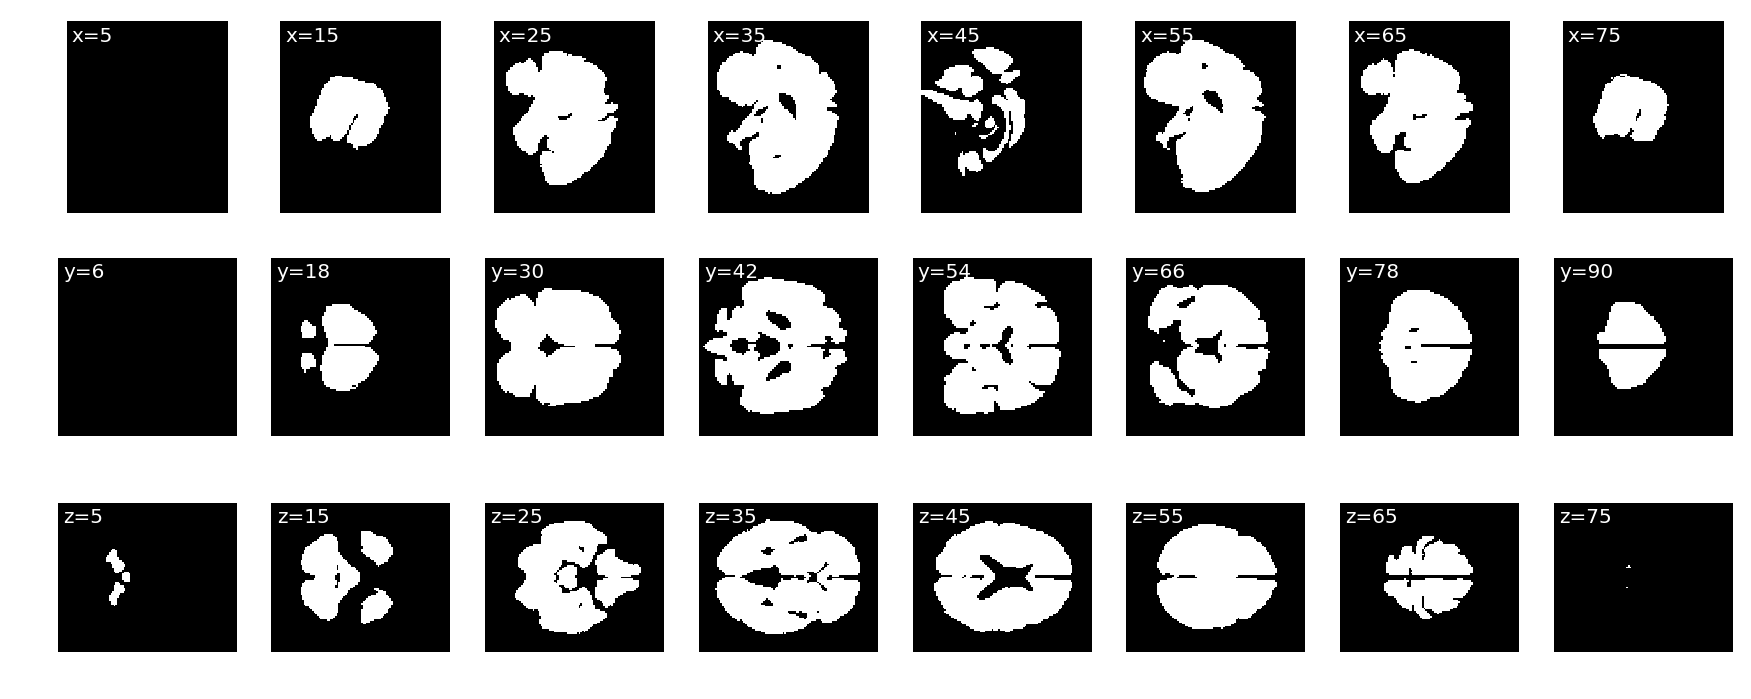

In [11]:
# TODO: What does z_factor do here?
# Load a mask that is applied to all nifti images and strips the skull etc.
mask = load_nifti('data/WM_GM_mask.nii.gz', z_factor=0.75)
plot_slices(mask)
mask.shape

In [21]:
e = 1e-6  # small perturbation to prevent zero division

# Explore data
This is mainly to figure out what the values of the input data are and which normalization makes sense.

In [22]:
all_struct_arr = np.zeros((10, 91, 109, 91))
for i, filename in enumerate(os.listdir(data_dir)[:10]):
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    all_struct_arr[i] = struct_arr

In [ ]:
def normalize(struct_arr):
    # Global normalization (i.e. subtract global mean and divide by global std).
    return (struct_arr - all_struct_arr.mean()) / (all_struct_arr.std() + e)
    # Voxelwise normalization.
    #return (struct_arr - all_struct_arr.mean(0)) / (all_struct_arr.std(0) + e)

In [23]:
which = 2

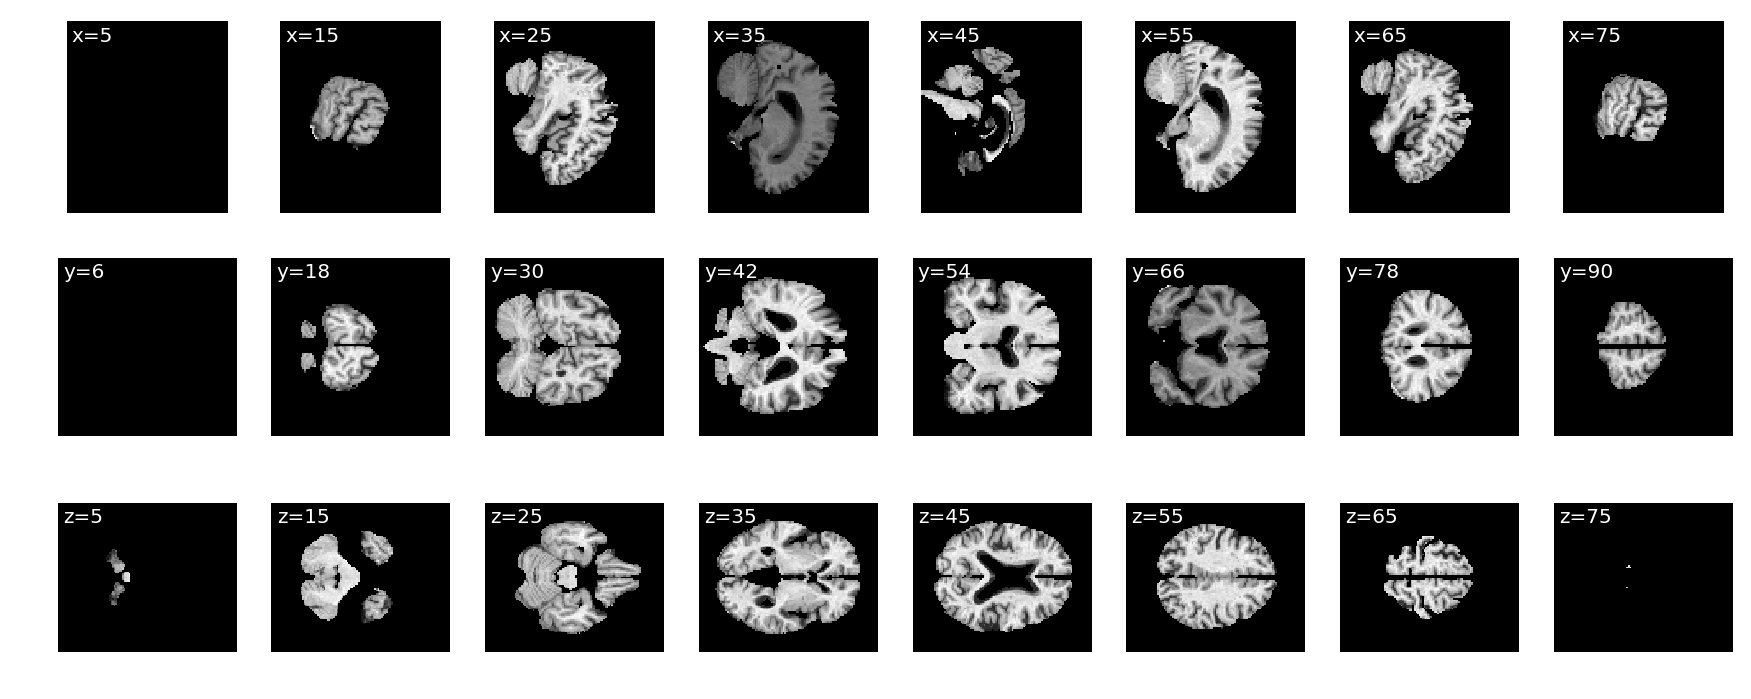

In [24]:
# Without normalization.
plot_slices(all_struct_arr[which])

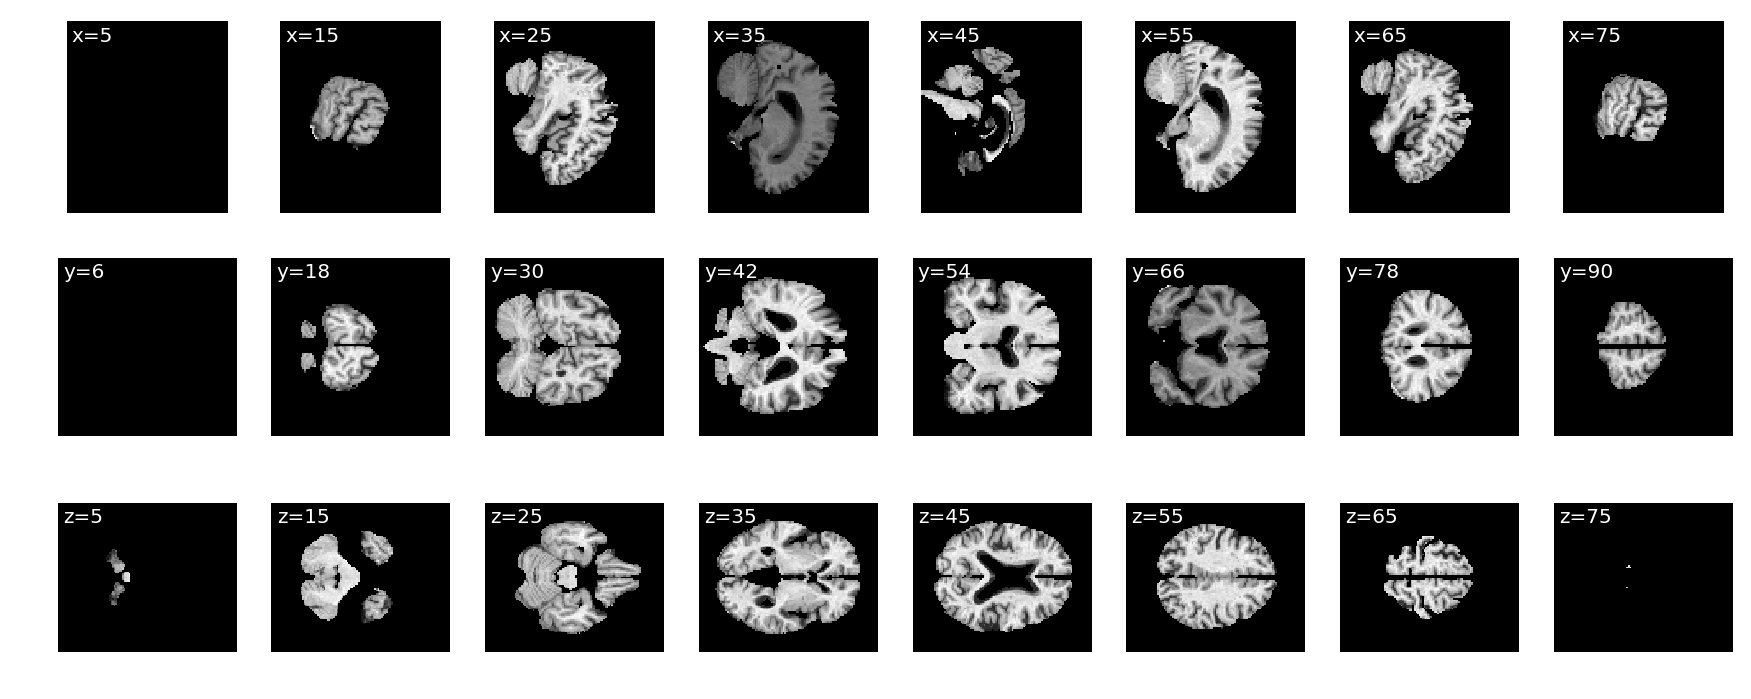

In [25]:
# With normalization.
plot_slices(normalize(all_struct_arr[which]))

In [31]:
from tabulate import tabulate

      min       max      mean       std
---------  --------  --------  --------
 -5.82113  2022.82   288.844   307.333
  0         913.135  122.275   145.668
  0         611.206   99.4162  108.139
  0        1379.34   168.501   178.928
  0         750.371  110.009   124.396
-13.0395   1031.41   171.719   181.533
  0         706.219   95.5286  111.081
 -1.75979   129.661   20.3127   22.7201
  0         707.953  122.843   130.472
  0         915.236  138.515   151.637


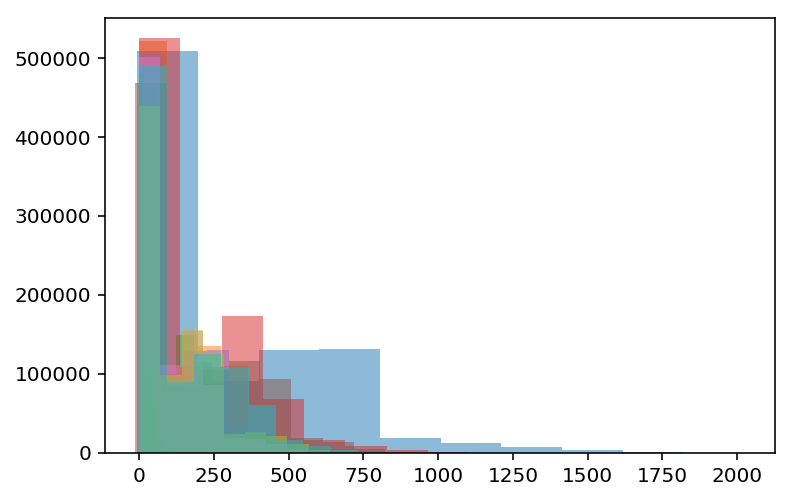

In [27]:
# Without mask.
table = []
for filename in os.listdir(data_dir)[:10]:
    struct_arr = load_nifti(os.path.join(data_dir, filename))
    table.append([struct_arr.min(), struct_arr.max(), struct_arr.mean(), struct_arr.std()])
    plt.hist(struct_arr.flatten(), alpha=0.5)
print(tabulate(table, headers=['min', 'max', 'mean', 'std']))

In [ ]:
# With mask.
table = []
for filename in os.listdir(data_dir)[:10]:
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    
    # Normalize.
    #struct_arr = (struct_arr - all_struct_arr.mean()) / (all_struct_arr.std() + e)
    
    table.append([struct_arr.min(), struct_arr.max(), struct_arr.mean(), struct_arr.std()])
    plt.hist(struct_arr.flatten(), alpha=0.5)
print(tabulate(table, headers=['min', 'max', 'mean', 'std']))

# Train pytorch model

In [67]:
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 64, 3)
        self.Conv_2 = nn.Conv3d(64, 64, 3)
        self.Conv_3 = nn.Conv3d(64, 64, 3)
        self.Conv_4 = nn.Conv3d(64, 64, 3)
        self.dense_1 = nn.Linear(128, 1)
        
    def forward(self, inp):
        x = F.elu(self.Conv_1(inp))  # TODO: Probably need relu for guided backprop!
        x = F.max_pool3d(x, 3)
        x = F.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 3)
        x = F.elu(self.Conv_3(x))
        x = F.elu(self.Conv_4(x))
        x = F.max_pool3d(x, 3)
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        
        # Only apply the sigmoid in eval mode, because during training we use the BCEWithLogitsLoss,
        # which includes the sigmoid and is numerically more stable.
        if not self.training:
            #print('Adding sigmoid')
            x = F.sigmoid(x)
            
        return x

In [68]:
net = ClassificationModel3D()

In [69]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

In [70]:
from torchsample.modules import ModuleTrainer
from torchsample.metrics import BinaryAccuracy

In [71]:
trainer = ModuleTrainer(net)
# TODO: Implement a metric BinaryAccuracyWithLogits to account for the BCEWithLogitsLoss function.
trainer.compile(loss=loss_function, optimizer=optimizer, metrics=[BinaryAccuracy()], callbacks=[])

In [72]:
trainer.summary([1, 91, 109, 91])

OrderedDict([('Conv3d-1',
              OrderedDict([('input_shape', [-1, 1L, 91L, 109L, 91L]),
                           ('output_shape', [-1, 64L, 89L, 107L, 89L]),
                           ('trainable', True),
                           ('nb_params', 1792)])),
             ('Conv3d-2',
              OrderedDict([('input_shape', [-1, 64L, 29L, 35L, 29L]),
                           ('output_shape', [-1, 64L, 27L, 33L, 27L]),
                           ('trainable', True),
                           ('nb_params', 110656)])),
             ('Conv3d-3',
              OrderedDict([('input_shape', [-1, 64L, 9L, 11L, 9L]),
                           ('output_shape', [-1, 64L, 7L, 9L, 7L]),
                           ('trainable', True),
                           ('nb_params', 110656)])),
             ('Conv3d-4',
              OrderedDict([('input_shape', [-1, 64L, 7L, 9L, 7L]),
                           ('output_shape', [-1, 64L, 5L, 7L, 5L]),
                           ('trainable', 

In [73]:
if torch.cuda.is_available():
    net = net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

GPU not available


In [ ]:
# TODO: This is a dirty workaround and only calculates the std across 10 images. Implement a nice way to get the std and mean across all samples.
# TODO: Do not actually calculate these values here, but preserve them somewhere.
pixel_std = all_struct_arr.std(0)

In [75]:
# TODO: Maybe inherit from torchsample.datasets.BaseDataset instead.
class ADNIDataset(Dataset):
    
    # TODO: Maybe give mask as filename here.
    def __init__(self, root_dir, mask=None, remove_nan=True, transform=None):
        self.root_dir = root_dir
        self.filenames = filter(lambda filename: filename.endswith('nii'), os.listdir(self.root_dir))
        print('Found', len(self.filenames), 'files')
        self.mask = mask
        self.remove_nan = remove_nan
        self.transform = transform
        
        # Required by torchsample.
        self.num_inputs = 1
        self.num_targets = 1
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        struct_arr = load_nifti(os.path.join(self.root_dir, filename), mask=self.mask, remove_nan=self.remove_nan)
    
        # TODO: Maybe do this (at least the normalization) via transforms.
        struct_arr = struct_arr / (pixel_std + e)
        struct_arr = struct_arr[None]  # add (empty) channel dimension
        struct_arr = torch.from_numpy(struct_arr).float()
        
        if self.transform is not None:
            struct_arr = self.transform(struct_arr)
        
        label = torch.ones(1) if filename.startswith('AD') else torch.zeros(1)
        return struct_arr, label

In [77]:
#import torchvision, torchsample 

#transform = torchvision.transforms.Compose([
#    torchsample.transforms.ToTensor(),  # do not use the torchvision version, as is also normalizes from (0, 255) to (0, 1)
#    # TODO: Try voxel-wise normalization here.
#    torchvision.transforms.Normalize([53], [125])
#])

In [78]:
train_dataset = ADNIDataset('data/adni-sample-split/train', mask=mask)
val_dataset = ADNIDataset('data/adni-sample-split/val', mask=mask)

Found 78 files
Found 10 files


In [79]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1) # pin_memory=True # CUDA only
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=1)

In [80]:
# TODO: acc_metric is flawed because in train mode, the network outputs the raw logits, so rounding these values and comparing to the true values doesn't make sense.
trainer.fit_loader(train_loader,
            val_loader=val_loader,
            num_epoch=20, 
            verbose=1,
            cuda_device=cuda_device)

Epoch 1/20: : 40 batches [03:03,  7.79s/ batches, acc_metric=8.4527, loss=14.3861, val_acc_metric=50.0000, val_loss=0.5885]                
Epoch 2/20: : 40 batches [03:15,  8.32s/ batches, acc_metric=41.4170, loss=0.7494, val_acc_metric=50.0000, val_loss=0.5864]                
Epoch 3/20: : 40 batches [02:53,  7.68s/ batches, acc_metric=53.3117, loss=0.6711, val_acc_metric=50.0000, val_loss=0.5822]                
Epoch 4/20:  21%|██        | 8/39 [00:30<02:02,  3.94s/ batches, acc_metric=32.7721, loss=0.6478]Process Process-11:
Traceback (most recent call last):
  File "/Users/d068730/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/d068730/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/d068730/anaconda/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/Users/d068730/anaconda/

KeyboardInterrupt: 

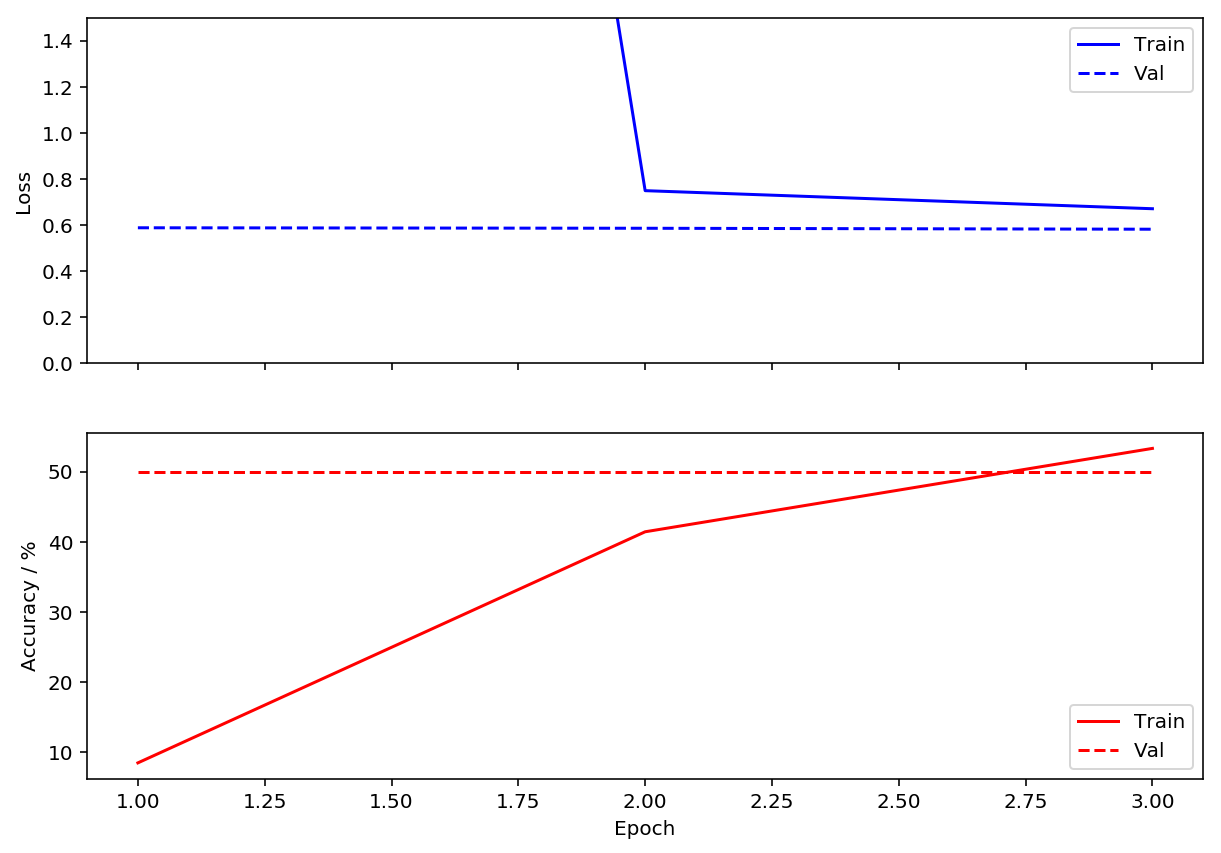

In [81]:
plot_learning_curve(trainer.history)

In [ ]:
# DEPRECATED: Manual training loop.
epochs = 40

for epoch in range(epochs):
    running_loss = 0
    
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs, labels = Variable(inputs), Variable(labels)
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        n = 10
        if batch % n == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch + 1, running_loss / n))
            running_loss = 0.0

# Convert keras model to pytorch
This was done as a first test to convert the existing keras model for ADNI (trained by Fabian, see [this notebook](https://github.com/derEitel/nn-experiments/blob/master/AD_NC_48_48.ipynb)) to pytorch. It is not used any more, but kept here for convenience.

In [ ]:
import keras

In [ ]:
model_filename = os.path.join(FOLDER, 'models/model_121217_1.h5')
model = keras.models.load_model(model_filename)

In [ ]:
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 64, 3)
        self.Conv_2 = nn.Conv3d(64, 64, 3)
        self.Conv_3 = nn.Conv3d(64, 64, 3)
        self.Conv_4 = nn.Conv3d(64, 64, 3)
        self.dense_1 = nn.Linear(128, 1)
        self.elu = nn.ELU()
        
    def forward(self, x):
        x = self.elu(self.Conv_1(x))  # TODO: Probably need relu for guided backprop!
        x = F.max_pool3d(x, 3)
        #plot_slices(x[0])
        x = self.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 3)
        x = self.elu(self.Conv_3(x))
        x = self.elu(self.Conv_4(x))
        x = F.max_pool3d(x, 3)
        
        # The permute operation converts the tensor from channels_first to channels_last format.
        # This is required to transfer a keras model that uses channels_last (pytorch uses channels_first by default).
        # Otherwise, the Flatten layer in keras and the view operation here output different values.
        # Remove this if the original keras network uses channels_first.
        x = x.permute(0, 2, 3, 4, 1).contiguous()
        
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.dense_1(x))
        return x
    
pytorch_model = ClassificationModel3D()

In [ ]:
list(pytorch_model.children())

In [ ]:
from nn_transfer import transfer

In [ ]:
transfer.keras_to_pytorch(model, pytorch_model)